In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Start Here 

In [62]:
## Cek Jumlah Files
def count_files(datasetFolders):
    paths = ['abnormal', 'normal']
    for path in paths:
        folder_path = os.path.join(datasetFolders, path)
        num_files = sum(1 for item in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, item)))
        print(f"Jumlah file di folder '{path}': {num_files}")

count_files('./readyToUsed')

Jumlah file di folder 'abnormal': 1000
Jumlah file di folder 'normal': 1000


In [63]:
# Untuk mengambil dan memberikan label dari data
def load_data(folder_path):
    data = []   # Untuk menyimpan data
    labels = [] # Untuk menyimpan label
    
    # Iterasi melalui setiap folder dalam folder_path
    for label in os.listdir(folder_path):
        label_folder_path = os.path.join(folder_path, label)
        
        # Pastikan itu adalah direktori
        if os.path.isdir(label_folder_path):
            label_data = []  # Untuk menyimpan data untuk label tertentu
            
            # Iterasi melalui setiap file dalam label_folder_path
            for file_name in os.listdir(label_folder_path):
                if file_name.endswith('.npy'):  # Hanya memproses file .npy
                    file_path = os.path.join(label_folder_path, file_name)
                    # Memuat data dari file .npy
                    label_data.append(np.load(file_path))
            
            # Menambahkan data dan label untuk label tertentu
            data.extend(label_data)
            if label == 'normal':
                # Label 0 untuk normal
                labels.extend([0] * len(label_data))  
            else:
                # Label 1 untuk abnormal
                labels.extend([1] * len(label_data))  
    
    return np.array(data), np.array(labels)

# Memuat data dari folder readyToUsed
data_folder = "./readyToUsed/"
X, y = load_data(data_folder)

# Memisahkan data menjadi set pelatihan dan set validasi
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Menyesuaikan ukuran data untuk model LSTM dan GRU (menambahkan dimensi waktu)
X_train = np.expand_dims(X_train, axis=1)  # Menambah dimensi waktu di posisi kedua
X_valid = np.expand_dims(X_valid, axis=1)

# Normalisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)

# Menampilkan ukuran setiap bagian data
print("Ukuran set pelatihan X:", X_train.shape)
print("Ukuran set pelatihan y:", y_train.shape)
print("Ukuran set validasi X:", X_valid.shape)
print("Ukuran set validasi y:", y_valid.shape)

Ukuran set pelatihan X: (1600, 1, 30000)
Ukuran set pelatihan y: (1600,)
Ukuran set validasi X: (400, 1, 30000)
Ukuran set validasi y: (400,)


In [64]:
# Simpan data ke dalam file menggunakan np.savez_compressed
np.savez_compressed('data_train_valid.npz', X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid)

## Build a Model Function 

In [8]:
def performsBaseModel(model, X_train, y_train, X_val, y_val, lr, epochs, names):
    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  patience=2,   # val_loss tidak mengalami penurunan dalam 2 epoch berturut-turut.
                                  factor=0.01,  # learning rate akan berkurang sebanyak 0.01
                                  min_lr=0.000001)
    
    earlystopping = EarlyStopping(monitor='val_loss', 
                                  patience=5, 
                                  restore_best_weights=True)

    callbacks = []
    
    # Compile the model with the appropriate optimizer
    if lr == 'auto':
        optimizer = Adam()
        callbacks.append(reduce_lr)
    else:
        optimizer = Adam(learning_rate=lr)

    # Determine the number of epochs
    if epochs == 'auto':
        epochs = 1000
        callbacks.append(earlystopping)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    # Fit the model
    history = model.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        validation_data=(X_val, y_val), 
                        callbacks=callbacks)
    
    print('Accuracy', history.history['accuracy'])
    print('Val Accuracy', history.history['val_accuracy'])
    print('Loss', history.history['loss'])
    print('Val Loss', history.history['val_loss'])
    
    # Buat subplots
    fig, axs = plt.subplots(2)

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'], label='Train')
    axs[0].plot(history.history['val_accuracy'], label='Validation')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'], label='Train')
    axs[1].plot(history.history['val_loss'], label='Validation')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper left')
    
    # Sesuaikan tata letak
    plt.show()

    # Membuat prediksi pada data validasi
    y_pred = model.predict(X_valid)
    
    # Konversi nilai probabilitas menjadi label biner (0 atau 1)
    y_pred_binary = (y_pred > 0.5)
    
    # Menampilkan confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_valid, y_pred_binary))

    # Menampilkan classification report
    print("Classification Report:")
    print(classification_report(y_valid, y_pred_binary))

    print("Model already save")
    model.save('rev_model/' + names + '.keras')

In [9]:
# Long Short Term Memory
def baseModel_LSTM(X_train, y_train, X_val, y_val, lr, epochs, names):
    model = Sequential([
        LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        LSTM(units=64),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    performsBaseModel(model, X_train, y_train, X_val, y_val, lr, epochs, names)


# Gated Recurrent Unit
def baseModel_GRU(X_train, y_train, X_val, y_val, lr, epochs, names):
    model = Sequential([
        GRU(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        GRU(units=64),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    performsBaseModel(model, X_train, y_train, X_val, y_val, lr, epochs, names)


# Temporal Convolutional Network
def baseModel_TCN(X_train, y_train, X_val, y_val, lr, epochs, names):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', 
               input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=1),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    performsBaseModel(model, X_train, y_train, X_val, y_val, lr, epochs, names)

## Epoch 10

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.7323 - loss: 0.5548 - val_accuracy: 0.7775 - val_loss: 0.5030
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.7884 - loss: 0.4674 - val_accuracy: 0.7750 - val_loss: 0.5364
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.8097 - loss: 0.4202 - val_accuracy: 0.7600 - val_loss: 0.4905
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8076 - loss: 0.4429 - val_accuracy: 0.7650 - val_loss: 0.5085
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7708 - loss: 0.4819 - val_accuracy: 0.7850 - val_loss: 0.4954
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7968 - loss: 0.4454 - val_accuracy: 0.8125 - val_loss: 0.4815
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7685 - loss: 0.4672 - val_accuracy: 0.7725 - val_loss: 0.5150
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8399 - loss: 0.3885 - val_accuracy: 0

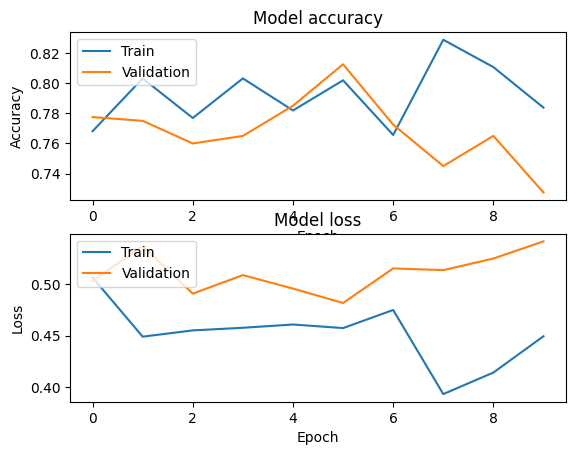

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Confusion Matrix:
[[144  57]
 [ 52 147]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       201
           1       0.72      0.74      0.73       199

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400

Model already save


In [10]:
# LSTM with learning rate (0.01) and epoch 10
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=10, names='1_LSTM_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.7051 - loss: 0.5636 - val_accuracy: 0.8150 - val_loss: 0.4466
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8383 - loss: 0.4034 - val_accuracy: 0.8350 - val_loss: 0.4174
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.8326 - loss: 0.3798 - val_accuracy: 0.8450 - val_loss: 0.4002
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8595 - loss: 0.3279 - val_accuracy: 0.8600 - val_loss: 0.3830
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.8546 - loss: 0.3423 - val_accuracy: 0.7975 - val_loss: 0.4777
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.8492 - loss: 0.3569 - val_accuracy: 0.8650 - val_loss: 0.3963
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8726 - loss: 0.3275 - val_accuracy: 0.8225 - val_loss: 0.4616
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8844 - loss: 0.2979 - val_accuracy: 0

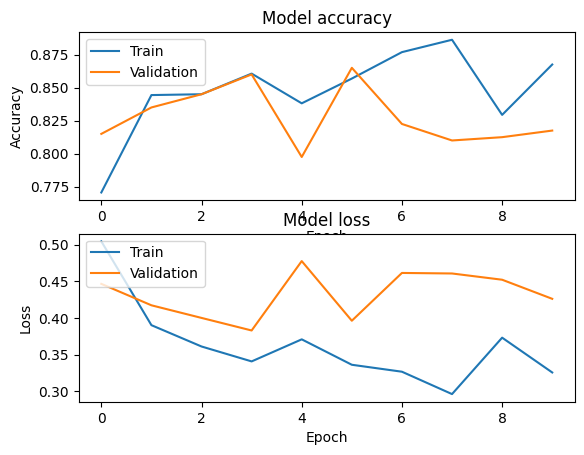

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Confusion Matrix:
[[155  46]
 [ 27 172]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       201
           1       0.79      0.86      0.82       199

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

Model already save


In [11]:
# LSTM with learning rate (0.001) and epoch 10
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=10, names='2_LSTM_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.7440 - loss: 0.5737 - val_accuracy: 0.8725 - val_loss: 0.4490
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.8748 - loss: 0.4126 - val_accuracy: 0.8950 - val_loss: 0.3722
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.8981 - loss: 0.3215 - val_accuracy: 0.8900 - val_loss: 0.3306
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9164 - loss: 0.2616 - val_accuracy: 0.9025 - val_loss: 0.2990
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9258 - loss: 0.2123 - val_accuracy: 0.8875 - val_loss: 0.3197
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9416 - loss: 0.1753 - val_accuracy: 0.8925 - val_loss: 0.2891
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9529 - loss: 0.1533 - val_accuracy: 0.9025 - val_loss: 0.2654
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9558 - loss: 0.1283 - val_accuracy: 0

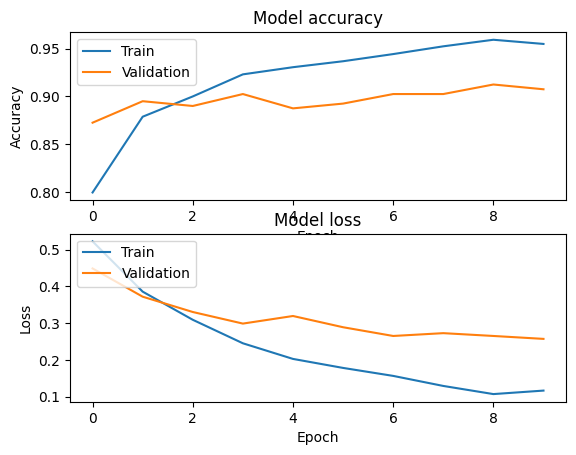

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Confusion Matrix:
[[186  15]
 [ 22 177]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       201
           1       0.92      0.89      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [12]:
# LSTM with learning rate (0.0001) and epoch 10
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=10, names='3_LSTM_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.7381 - loss: 0.5677 - val_accuracy: 0.8400 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.8527 - loss: 0.3773 - val_accuracy: 0.8425 - val_loss: 0.4093 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8473 - loss: 0.3711 - val_accuracy: 0.8075 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.8616 - loss: 0.3380 - val_accuracy: 0.8625 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8314 - loss: 0.3712 - val_accuracy: 0.7875 - val_loss: 0.4779 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8605 - loss: 0.3459 - val_accuracy: 0.8200 - val_loss: 0.4301 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8400 - loss: 0.3398 -

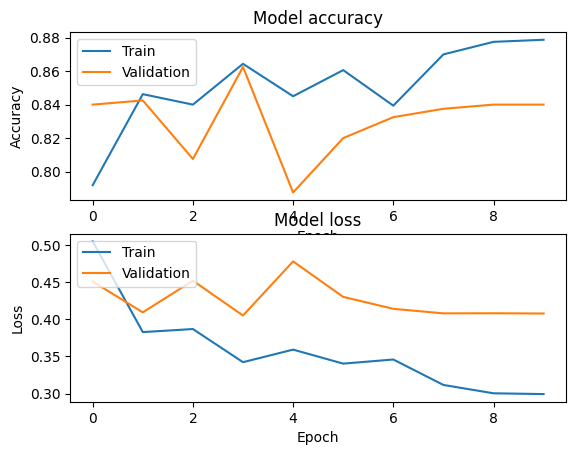

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Confusion Matrix:
[[177  24]
 [ 40 159]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       201
           1       0.87      0.80      0.83       199

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400

Model already save


In [14]:
# LSTM with learning rate (auto) and epoch 10
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr='auto', epochs=10, names='4_LSTM_lr_auto')

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.7139 - loss: 0.5560 - val_accuracy: 0.7925 - val_loss: 0.4771
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.7704 - loss: 0.4879 - val_accuracy: 0.7775 - val_loss: 0.4545
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.7850 - loss: 0.4796 - val_accuracy: 0.7850 - val_loss: 0.4647
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.7670 - loss: 0.4809 - val_accuracy: 0.7225 - val_loss: 0.5471
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.7639 - loss: 0.4914 - val_accuracy: 0.7875 - val_loss: 0.4905
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8136 - loss: 0.4312 - val_accuracy: 0.8100 - val_loss: 0.4672
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.7929 - loss: 0.4499 - val_accuracy: 0.7425 - val_loss: 0.5036
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.7856 - loss: 0.4463 - val_accuracy: 0

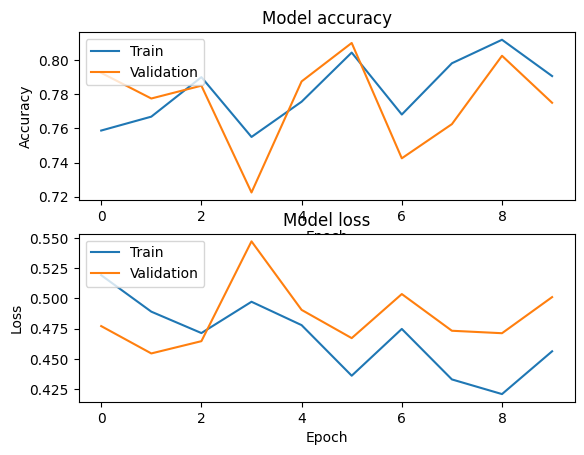

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Confusion Matrix:
[[130  71]
 [ 19 180]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74       201
           1       0.72      0.90      0.80       199

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.77       400
weighted avg       0.80      0.78      0.77       400

Model already save


In [16]:
# GRU with learning rate (0.01) and epoch 10
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=10, names='5_GRU_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.6962 - loss: 0.5698 - val_accuracy: 0.8375 - val_loss: 0.4461
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8481 - loss: 0.3820 - val_accuracy: 0.7875 - val_loss: 0.4361
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8393 - loss: 0.3727 - val_accuracy: 0.8450 - val_loss: 0.3983
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.8741 - loss: 0.3190 - val_accuracy: 0.8200 - val_loss: 0.4261
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8638 - loss: 0.3364 - val_accuracy: 0.8650 - val_loss: 0.3873
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.8898 - loss: 0.2886 - val_accuracy: 0.8475 - val_loss: 0.4261
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.8797 - loss: 0.3046 - val_accuracy: 0.8175 - val_loss: 0.4246
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.8610 - loss: 0.3363 - val_accuracy: 0.

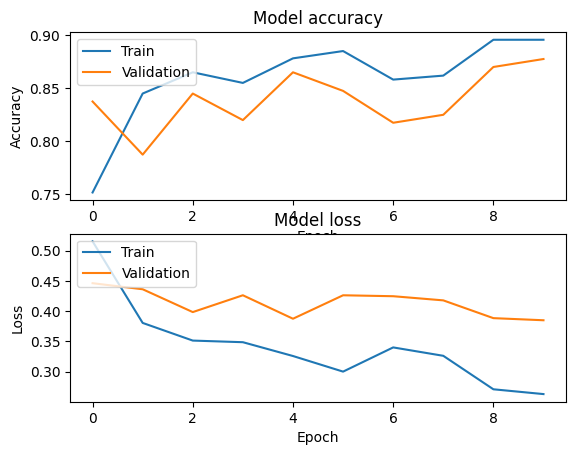

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Confusion Matrix:
[[181  20]
 [ 29 170]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       201
           1       0.89      0.85      0.87       199

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400

Model already save


In [17]:
# GRU with learning rate (0.001) and epoch 10
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=10, names='6_GRU_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.7500 - loss: 0.5222 - val_accuracy: 0.8650 - val_loss: 0.4088
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8755 - loss: 0.3461 - val_accuracy: 0.8575 - val_loss: 0.3627
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9051 - loss: 0.2706 - val_accuracy: 0.8900 - val_loss: 0.3287
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9230 - loss: 0.2352 - val_accuracy: 0.8925 - val_loss: 0.2975
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9367 - loss: 0.1898 - val_accuracy: 0.8775 - val_loss: 0.3114
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9324 - loss: 0.1819 - val_accuracy: 0.9150 - val_loss: 0.2706
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9543 - loss: 0.1248 - val_accuracy: 0.9075 - val_loss: 0.2793
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9664 - loss: 0.1031 - val_accuracy: 0

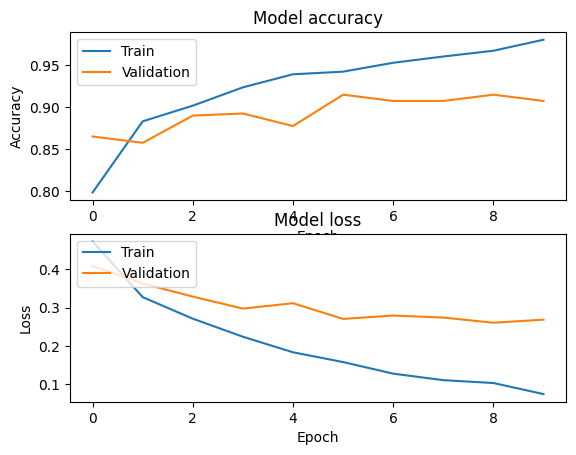

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Confusion Matrix:
[[189  12]
 [ 25 174]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       201
           1       0.94      0.87      0.90       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [18]:
# GRU with learning rate (0.0001) and epoch 10
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=10, names='7_GRU_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.7168 - loss: 0.5572 - val_accuracy: 0.8425 - val_loss: 0.4420 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8553 - loss: 0.3840 - val_accuracy: 0.8425 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.8532 - loss: 0.3535 - val_accuracy: 0.8650 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8784 - loss: 0.3165 - val_accuracy: 0.8550 - val_loss: 0.3966 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.8628 - loss: 0.3155 - val_accuracy: 0.8500 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.8882 - loss: 0.2837 - val_accuracy: 0.8575 - val_loss: 0.3962 - learning_rate: 1.0000e-05
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9083 - loss: 0.26

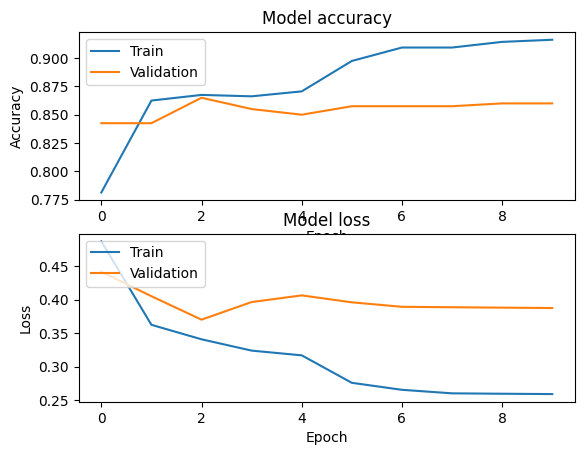

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Confusion Matrix:
[[175  26]
 [ 30 169]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       201
           1       0.87      0.85      0.86       199

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400

Model already save


In [20]:
# GRU with learning rate (auto) and epoch 10
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr='auto', epochs=10, names='8_GRU_lr_auto')

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.6388 - loss: 15.7037 - val_accuracy: 0.7550 - val_loss: 1.8357
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.7586 - loss: 1.3359 - val_accuracy: 0.7700 - val_loss: 0.7356
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.8323 - loss: 0.4962 - val_accuracy: 0.8425 - val_loss: 0.4762
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.8909 - loss: 0.2871 - val_accuracy: 0.8900 - val_loss: 0.5259
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9086 - loss: 0.2336 - val_accuracy: 0.9050 - val_loss: 0.4848
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - accuracy: 0.9298 - loss: 0.2040 - val_accuracy: 0.8950 - val_loss: 0.4946
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.9459 - loss: 0.1548 - val_accuracy: 0.9000 - val_loss: 0.4388
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.9404 - loss: 0.1583 - val_acc

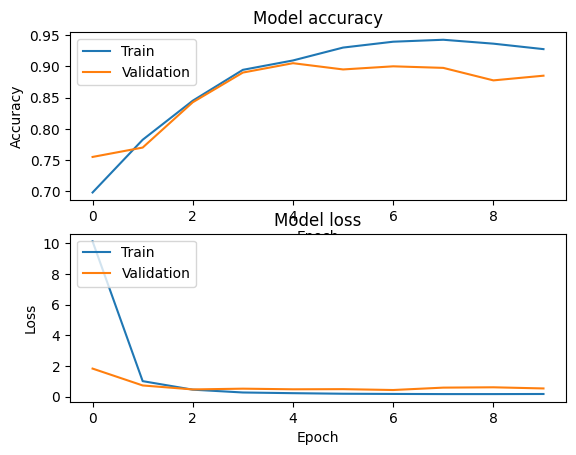

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Confusion Matrix:
[[194   7]
 [ 39 160]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       201
           1       0.96      0.80      0.87       199

    accuracy                           0.89       400
   macro avg       0.90      0.88      0.88       400
weighted avg       0.90      0.89      0.88       400

Model already save


In [22]:
# TCN with learning rate (0.01) and epoch 10
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=10, names='9_TCN_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.7358 - loss: 1.1365 - val_accuracy: 0.7675 - val_loss: 1.0081
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.8620 - loss: 0.5881 - val_accuracy: 0.8125 - val_loss: 0.6569
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.8530 - loss: 0.5230 - val_accuracy: 0.8575 - val_loss: 0.5882
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.9151 - loss: 0.3096 - val_accuracy: 0.8100 - val_loss: 0.7866
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.9070 - loss: 0.3597 - val_accuracy: 0.8900 - val_loss: 0.4922
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.9606 - loss: 0.1294 - val_accuracy: 0.8900 - val_loss: 0.5651
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.9701 - loss: 0.1134 - val_accuracy: 0.9150 - val_loss: 0.4149
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.9871 - loss: 0.0398 - val_accu

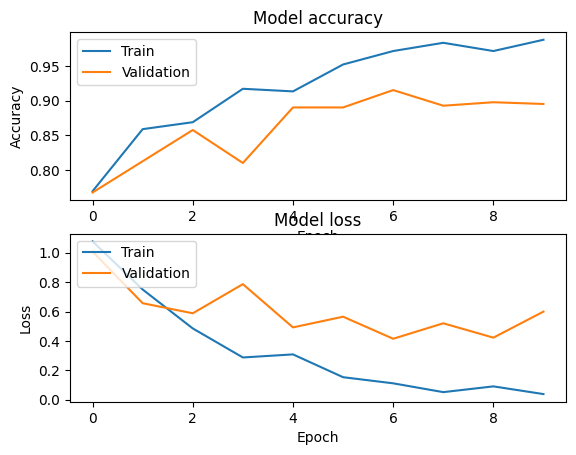

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:
[[175  26]
 [ 16 183]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       201
           1       0.88      0.92      0.90       199

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.89       400
weighted avg       0.90      0.90      0.89       400

Model already save


In [23]:
# TCN with learning rate (0.001) and epoch 10
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=10, names='10_TCN_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step - accuracy: 0.7249 - loss: 0.5359 - val_accuracy: 0.8675 - val_loss: 0.3905
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.9040 - loss: 0.2847 - val_accuracy: 0.8575 - val_loss: 0.3791
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.9375 - loss: 0.1923 - val_accuracy: 0.9125 - val_loss: 0.3091
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.9616 - loss: 0.1249 - val_accuracy: 0.9150 - val_loss: 0.3169
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.9804 - loss: 0.0934 - val_accuracy: 0.9075 - val_loss: 0.3408
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.9926 - loss: 0.0542 - val_accuracy: 0.9000 - val_loss: 0.4470
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step - accuracy: 0.9717 - loss: 0.0927 - val_accuracy: 0.8825 - val_loss: 0.3691
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.9896 - loss: 0.0421 - val_accu

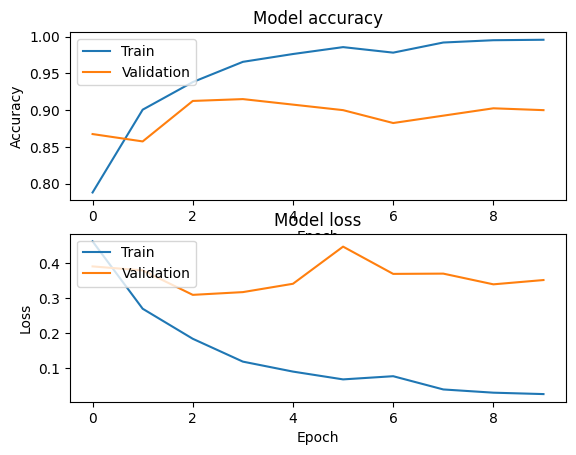

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:
[[190  11]
 [ 29 170]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.90       201
           1       0.94      0.85      0.89       199

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

Model already save


In [24]:
# TCN with learning rate (0.0001) and epoch 10
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=10, names='11_TCN_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.7275 - loss: 0.8547 - val_accuracy: 0.8475 - val_loss: 0.7939 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.8654 - loss: 0.5137 - val_accuracy: 0.8525 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.9049 - loss: 0.4398 - val_accuracy: 0.8450 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.9291 - loss: 0.2487 - val_accuracy: 0.9000 - val_loss: 0.6010 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.9737 - loss: 0.0901 - val_accuracy: 0.9050 - val_loss: 0.5693 - learning_rate: 1.0000e-05
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - accuracy: 0.9816 - loss: 0.0529 - val_accuracy: 0.9025 - val_loss: 0.5472 - learning_rate: 1.0000e-05
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step - accuracy: 0.9726 - 

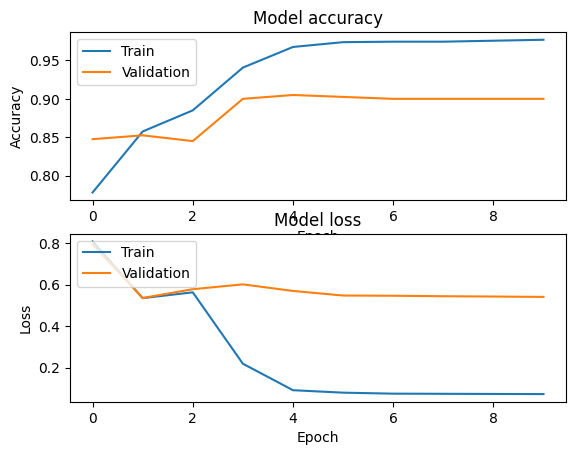

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step
Confusion Matrix:
[[184  17]
 [ 23 176]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       201
           1       0.91      0.88      0.90       199

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

Model already save


In [25]:
# TCN with learning rate (auto) and epoch 10
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr='auto', epochs=10, names='12_TCN_lr_auto')

## Epoch 20

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.7209 - loss: 0.5506 - val_accuracy: 0.7725 - val_loss: 0.4943
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7982 - loss: 0.4672 - val_accuracy: 0.7775 - val_loss: 0.4828
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.8263 - loss: 0.4196 - val_accuracy: 0.8225 - val_loss: 0.4775
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.7848 - loss: 0.4766 - val_accuracy: 0.7350 - val_loss: 0.5107
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7918 - loss: 0.4534 - val_accuracy: 0.7700 - val_loss: 0.5008
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.8013 - loss: 0.4373 - val_accuracy: 0.7425 - val_loss: 0.5034
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7973 - loss: 0.4338 - val_accuracy: 0.7825 - val_loss: 0.4745
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7886 - loss: 0.4546 - val_accuracy: 

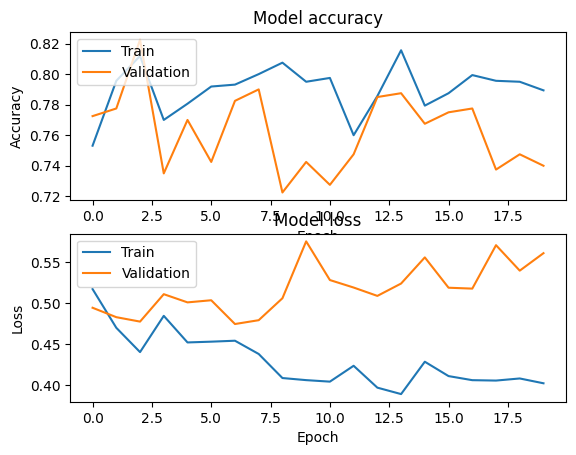

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Confusion Matrix:
[[120  81]
 [ 23 176]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.60      0.70       201
           1       0.68      0.88      0.77       199

    accuracy                           0.74       400
   macro avg       0.76      0.74      0.73       400
weighted avg       0.76      0.74      0.73       400

Model already save


In [26]:
# LSTM with learning rate (0.01) and epoch 20
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=20, names='13_LSTM_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.7364 - loss: 0.5652 - val_accuracy: 0.8600 - val_loss: 0.4153
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.8496 - loss: 0.3702 - val_accuracy: 0.8425 - val_loss: 0.4133
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8529 - loss: 0.3739 - val_accuracy: 0.8575 - val_loss: 0.3698
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8622 - loss: 0.3399 - val_accuracy: 0.8675 - val_loss: 0.3604
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8815 - loss: 0.2937 - val_accuracy: 0.8550 - val_loss: 0.3956
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.8764 - loss: 0.3062 - val_accuracy: 0.8650 - val_loss: 0.3966
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8745 - loss: 0.2900 - val_accuracy: 0.8575 - val_loss: 0.3976
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8909 - loss: 0.2913 - val_accuracy: 0

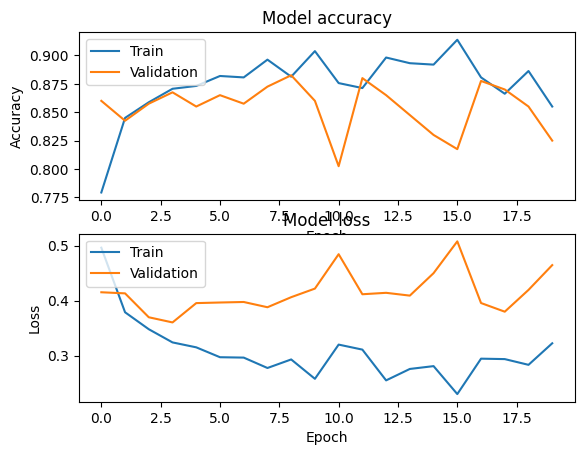

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Confusion Matrix:
[[150  51]
 [ 19 180]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       201
           1       0.78      0.90      0.84       199

    accuracy                           0.82       400
   macro avg       0.83      0.83      0.82       400
weighted avg       0.83      0.82      0.82       400

Model already save


In [27]:
# LSTM with learning rate (0.001) and epoch 20
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=20, names='14_LSTM_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.7608 - loss: 0.5712 - val_accuracy: 0.8650 - val_loss: 0.4613
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8574 - loss: 0.4149 - val_accuracy: 0.8750 - val_loss: 0.3928
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9061 - loss: 0.3207 - val_accuracy: 0.8875 - val_loss: 0.3464
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9224 - loss: 0.2643 - val_accuracy: 0.9000 - val_loss: 0.3136
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9355 - loss: 0.2150 - val_accuracy: 0.9025 - val_loss: 0.2924
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.9450 - loss: 0.1871 - val_accuracy: 0.8825 - val_loss: 0.3060
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9403 - loss: 0.1734 - val_accuracy: 0.8850 - val_loss: 0.3052
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9468 - loss: 0.1511 - val_accuracy: 0

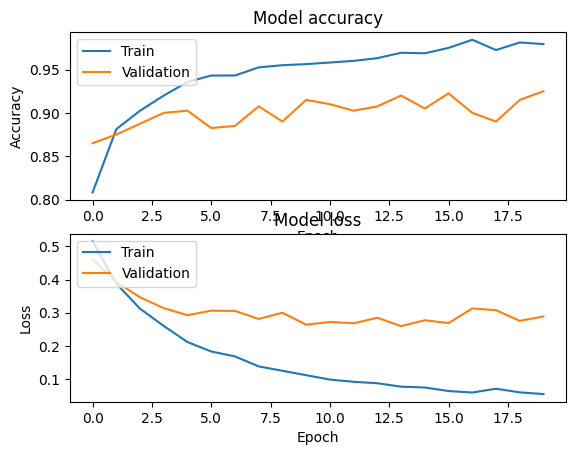

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Confusion Matrix:
[[190  11]
 [ 19 180]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       201
           1       0.94      0.90      0.92       199

    accuracy                           0.93       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.93      0.92       400

Model already save


In [28]:
# LSTM with learning rate (0.0001) and epoch 20
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=20, names='15_LSTM_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.7044 - loss: 0.5625 - val_accuracy: 0.8450 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8582 - loss: 0.3716 - val_accuracy: 0.8350 - val_loss: 0.4196 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8593 - loss: 0.3624 - val_accuracy: 0.8425 - val_loss: 0.4104 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.8749 - loss: 0.3268 - val_accuracy: 0.8125 - val_loss: 0.4744 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8266 - loss: 0.3882 - val_accuracy: 0.8275 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8479 - loss: 0.3458 - val_accuracy: 0.8475 - val_loss: 0.4145 - learning_rate: 1.0000e-05
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.8618 - loss: 0.3

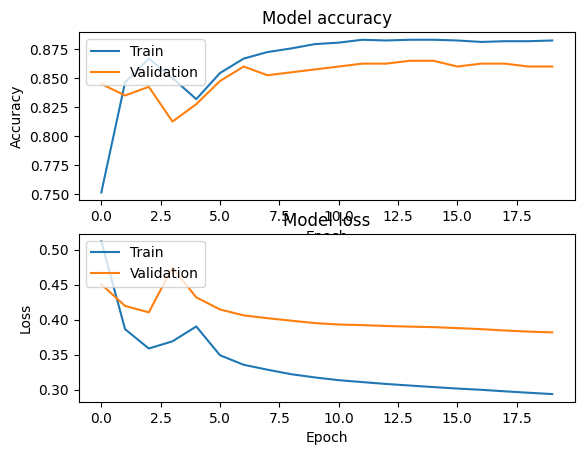

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Confusion Matrix:
[[174  27]
 [ 29 170]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       201
           1       0.86      0.85      0.86       199

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400

Model already save


In [29]:
# LSTM with learning rate (auto) and epoch 20
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr='auto', epochs=20, names='16_LSTM_lr_auto')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.7020 - loss: 0.5700 - val_accuracy: 0.7275 - val_loss: 0.5385
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7867 - loss: 0.4909 - val_accuracy: 0.7650 - val_loss: 0.5583
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7569 - loss: 0.5180 - val_accuracy: 0.7525 - val_loss: 0.5267
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.7814 - loss: 0.4785 - val_accuracy: 0.7800 - val_loss: 0.4692
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7962 - loss: 0.4470 - val_accuracy: 0.7800 - val_loss: 0.5058
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.7578 - loss: 0.4982 - val_accuracy: 0.7350 - val_loss: 0.5105
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7950 - loss: 0.4367 - val_accuracy: 0.7225 - val_loss: 0.5442
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7944 - loss: 0.4330 - val_accuracy: 0.

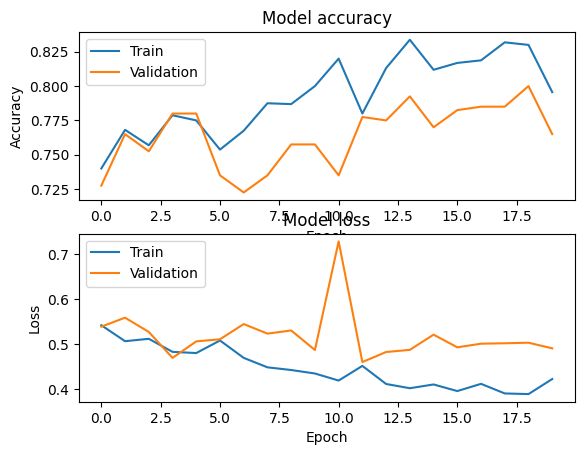

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:
[[128  73]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73       201
           1       0.71      0.89      0.79       199

    accuracy                           0.77       400
   macro avg       0.78      0.77      0.76       400
weighted avg       0.78      0.77      0.76       400

Model already save


In [30]:
# GRU with learning rate (0.01) and epoch 20
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=20, names='17_GRU_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.7027 - loss: 0.5675 - val_accuracy: 0.8300 - val_loss: 0.4318
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8620 - loss: 0.3670 - val_accuracy: 0.8500 - val_loss: 0.4102
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8594 - loss: 0.3491 - val_accuracy: 0.8600 - val_loss: 0.4047
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8816 - loss: 0.3199 - val_accuracy: 0.8625 - val_loss: 0.3756
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8924 - loss: 0.2882 - val_accuracy: 0.8475 - val_loss: 0.3705
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8696 - loss: 0.2939 - val_accuracy: 0.8525 - val_loss: 0.4178
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8729 - loss: 0.3007 - val_accuracy: 0.8775 - val_loss: 0.3673
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8824 - loss: 0.2857 - val_accuracy: 0.

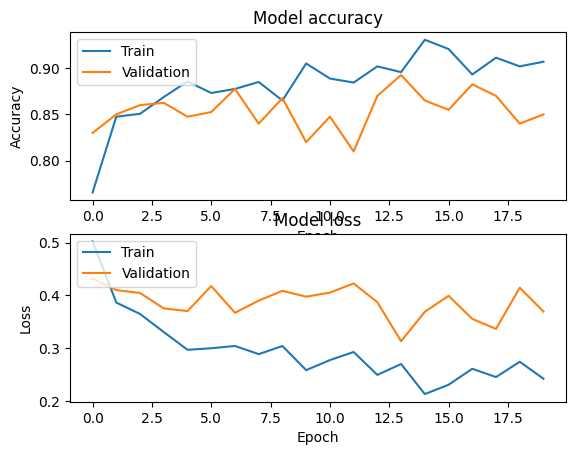

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Confusion Matrix:
[[179  22]
 [ 38 161]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       201
           1       0.88      0.81      0.84       199

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

Model already save


In [31]:
# GRU with learning rate (0.001) and epoch 20
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=20, names='18_GRU_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.7626 - loss: 0.5133 - val_accuracy: 0.8825 - val_loss: 0.3849
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8880 - loss: 0.3356 - val_accuracy: 0.8875 - val_loss: 0.3328
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9197 - loss: 0.2545 - val_accuracy: 0.8900 - val_loss: 0.3274
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9311 - loss: 0.2172 - val_accuracy: 0.8800 - val_loss: 0.3208
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9289 - loss: 0.1903 - val_accuracy: 0.8875 - val_loss: 0.2946
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9406 - loss: 0.1529 - val_accuracy: 0.8675 - val_loss: 0.3134
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9495 - loss: 0.1350 - val_accuracy: 0.9125 - val_loss: 0.2561
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9578 - loss: 0.0983 - val_accuracy: 0

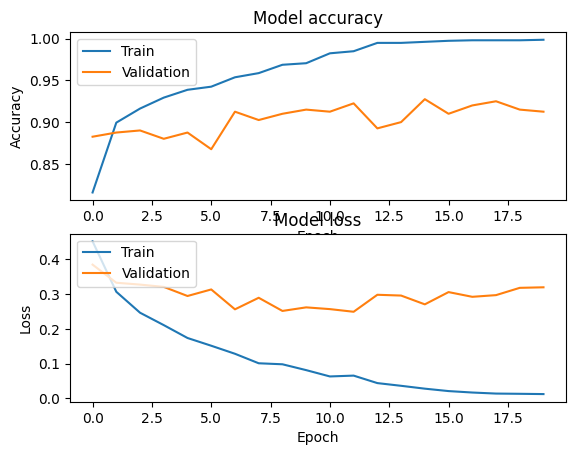

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Confusion Matrix:
[[189  12]
 [ 23 176]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       201
           1       0.94      0.88      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [32]:
# GRU with learning rate (0.0001) and epoch 20
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=20, names='19_GRU_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.7727 - loss: 0.4887 - val_accuracy: 0.8575 - val_loss: 0.4056 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8289 - loss: 0.3990 - val_accuracy: 0.7525 - val_loss: 0.5311 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8186 - loss: 0.4042 - val_accuracy: 0.8475 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8791 - loss: 0.3433 - val_accuracy: 0.8500 - val_loss: 0.4216 - learning_rate: 1.0000e-05
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8676 - loss: 0.3486 - val_accuracy: 0.8500 - val_loss: 0.4158 - learning_rate: 1.0000e-05
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8803 - loss: 0.3385 - val_accuracy: 0.8500 - val_loss: 0.4153 - learning_rate: 1.0000e-06
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8595 - lo

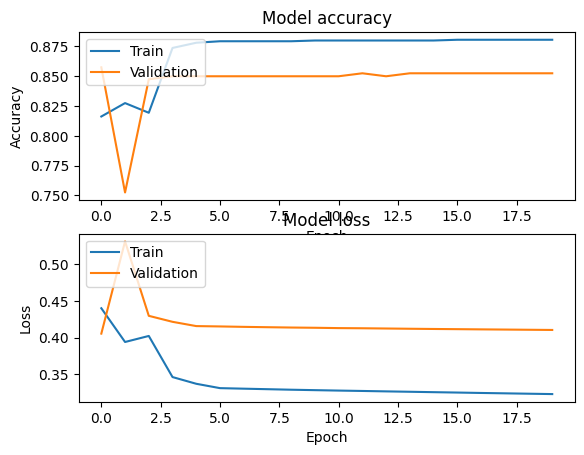

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Confusion Matrix:
[[168  33]
 [ 26 173]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       201
           1       0.84      0.87      0.85       199

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

Model already save


In [33]:
# GRU with learning rate (auto) and epoch 20
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr='auto', epochs=20, names='20_GRU_lr_auto')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.6023 - loss: 16.1304 - val_accuracy: 0.8250 - val_loss: 0.9812
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.7728 - loss: 0.8161 - val_accuracy: 0.7875 - val_loss: 0.9285
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.8607 - loss: 0.5548 - val_accuracy: 0.8750 - val_loss: 0.3884
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.9035 - loss: 0.2777 - val_accuracy: 0.8050 - val_loss: 0.4663
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.9091 - loss: 0.2553 - val_accuracy: 0.8200 - val_loss: 0.6189
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.9322 - loss: 0.2103 - val_accuracy: 0.8775 - val_loss: 0.4438
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.9059 - loss: 0.2616 - val_accuracy: 0.8750 - val_loss: 0.4825
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.9424 - loss: 0.1790 - val_acc

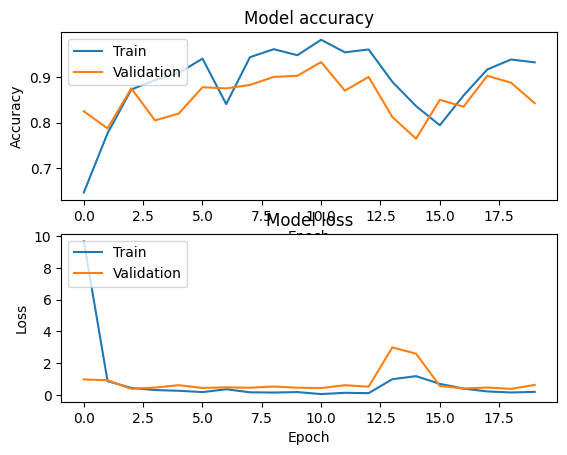

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Confusion Matrix:
[[189  12]
 [ 51 148]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       201
           1       0.93      0.74      0.82       199

    accuracy                           0.84       400
   macro avg       0.86      0.84      0.84       400
weighted avg       0.86      0.84      0.84       400

Model already save


In [34]:
# TCN with learning rate (0.01) and epoch 20
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=20, names='21_TCN_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 257ms/step - accuracy: 0.7569 - loss: 0.8990 - val_accuracy: 0.8500 - val_loss: 0.6855
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9216 - loss: 0.2538 - val_accuracy: 0.8950 - val_loss: 0.3719
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.9187 - loss: 0.2641 - val_accuracy: 0.8150 - val_loss: 0.7624
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.9194 - loss: 0.2691 - val_accuracy: 0.8775 - val_loss: 0.4537
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.9455 - loss: 0.1608 - val_accuracy: 0.8775 - val_loss: 0.7287
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.9613 - loss: 0.0970 - val_accuracy: 0.9225 - val_loss: 0.4691
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.9750 - loss: 0.0910 - val_accuracy: 0.9000 - val_loss: 0.5030
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.9665 - loss: 0.1127 - val_accu

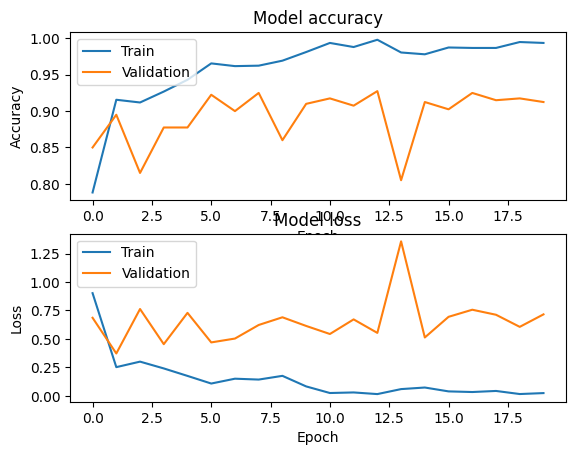

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Confusion Matrix:
[[186  15]
 [ 20 179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       201
           1       0.92      0.90      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [35]:
# TCN with learning rate (0.001) and epoch 20
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=20, names='22_TCN_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.7363 - loss: 0.5374 - val_accuracy: 0.8675 - val_loss: 0.3697
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.9051 - loss: 0.2670 - val_accuracy: 0.8800 - val_loss: 0.3416
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9300 - loss: 0.2035 - val_accuracy: 0.9100 - val_loss: 0.3059
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.9569 - loss: 0.1403 - val_accuracy: 0.9075 - val_loss: 0.2933
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.9749 - loss: 0.0912 - val_accuracy: 0.9150 - val_loss: 0.2962
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - accuracy: 0.9878 - loss: 0.0584 - val_accuracy: 0.9200 - val_loss: 0.2951
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - accuracy: 0.9897 - loss: 0.0580 - val_accuracy: 0.8750 - val_loss: 0.3538
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.9968 - loss: 0.0311 - val_accu

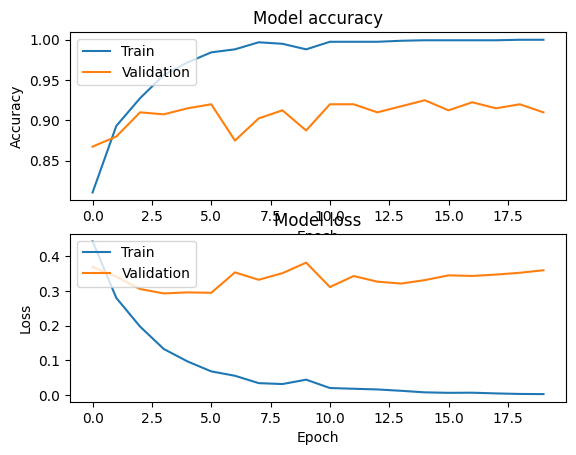

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Confusion Matrix:
[[189  12]
 [ 24 175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       201
           1       0.94      0.88      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [36]:
# TCN with learning rate (0.0001) and epoch 20
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=20, names='23_TCN_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.6799 - loss: 1.2477 - val_accuracy: 0.7975 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.8551 - loss: 0.4498 - val_accuracy: 0.8675 - val_loss: 0.6145 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.9030 - loss: 0.2593 - val_accuracy: 0.8775 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9450 - loss: 0.2192 - val_accuracy: 0.8350 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - accuracy: 0.9502 - loss: 0.1404 - val_accuracy: 0.8775 - val_loss: 0.4825 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.9675 - loss: 0.0950 - val_accuracy: 0.9050 - val_loss: 0.4326 - learning_rate: 1.0000e-05
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9783 - loss

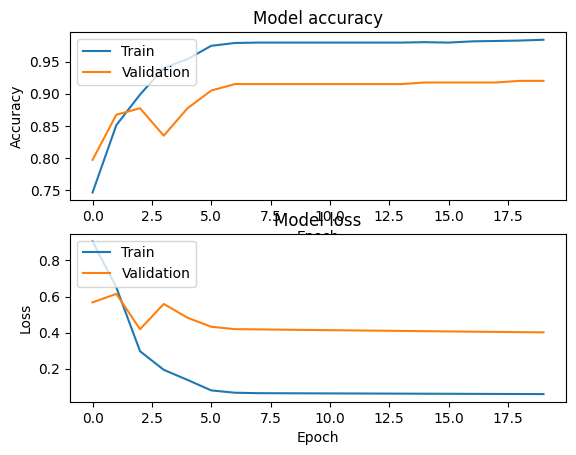

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Confusion Matrix:
[[189  12]
 [ 20 179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       201
           1       0.94      0.90      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

Model already save


In [37]:
# TCN with learning rate (auto) and epoch 20
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr='auto', epochs=20, names='24_TCN_lr_auto')

## Epoch 30

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.7178 - loss: 0.5679 - val_accuracy: 0.7050 - val_loss: 0.5514
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7576 - loss: 0.5157 - val_accuracy: 0.7050 - val_loss: 0.5703
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7418 - loss: 0.5195 - val_accuracy: 0.7175 - val_loss: 0.5163
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.7916 - loss: 0.4392 - val_accuracy: 0.7400 - val_loss: 0.5256
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7425 - loss: 0.5051 - val_accuracy: 0.7550 - val_loss: 0.4993
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.7603 - loss: 0.4809 - val_accuracy: 0.7725 - val_loss: 0.4821
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8020 - loss: 0.4394 - val_accuracy: 0.7925 - val_loss: 0.4988
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.7794 - loss: 0.4425 - val_accuracy: 0

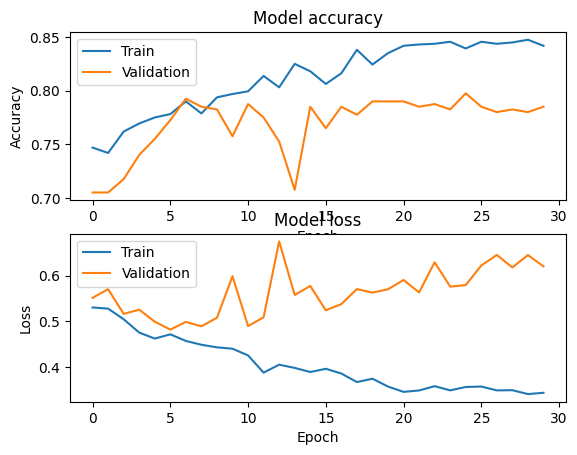

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Confusion Matrix:
[[146  55]
 [ 31 168]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       201
           1       0.75      0.84      0.80       199

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.78       400
weighted avg       0.79      0.79      0.78       400

Model already save


In [50]:
# LSTM with learning rate (0.01) and epoch 30
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=30, names='25_LSTM_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.7172 - loss: 0.5773 - val_accuracy: 0.8500 - val_loss: 0.4439
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8628 - loss: 0.3716 - val_accuracy: 0.8125 - val_loss: 0.4330
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8605 - loss: 0.3395 - val_accuracy: 0.8225 - val_loss: 0.4459
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.8789 - loss: 0.3047 - val_accuracy: 0.8275 - val_loss: 0.4227
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8537 - loss: 0.3330 - val_accuracy: 0.8375 - val_loss: 0.4141
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.8841 - loss: 0.2912 - val_accuracy: 0.8725 - val_loss: 0.3742
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8903 - loss: 0.2672 - val_accuracy: 0.8600 - val_loss: 0.4000
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.8921 - loss: 0.2625 - val_accuracy: 0

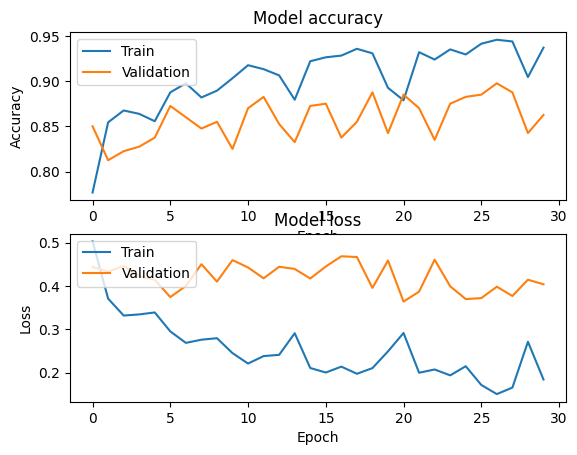

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Confusion Matrix:
[[187  14]
 [ 41 158]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       201
           1       0.92      0.79      0.85       199

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400

Model already save


In [51]:
# LSTM with learning rate (0.001) and epoch 30
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=30, names='26_LSTM_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.7510 - loss: 0.5810 - val_accuracy: 0.8500 - val_loss: 0.4751
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.8859 - loss: 0.4042 - val_accuracy: 0.8775 - val_loss: 0.3903
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9081 - loss: 0.3247 - val_accuracy: 0.8750 - val_loss: 0.3527
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9130 - loss: 0.2687 - val_accuracy: 0.8975 - val_loss: 0.3133
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9407 - loss: 0.2176 - val_accuracy: 0.8675 - val_loss: 0.3337
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9378 - loss: 0.2005 - val_accuracy: 0.8900 - val_loss: 0.2979
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.9354 - loss: 0.1807 - val_accuracy: 0.8800 - val_loss: 0.3079
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9530 - loss: 0.1510 - val_accuracy: 0

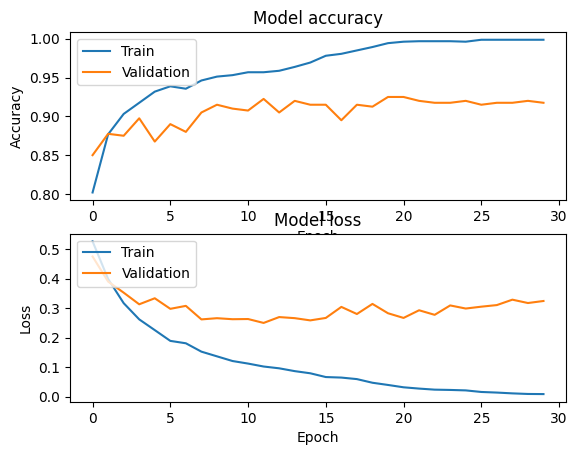

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Confusion Matrix:
[[189  12]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       201
           1       0.94      0.89      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

Model already save


In [52]:
# LSTM with learning rate (0.0001) and epoch 30
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=30, names='27_LSTM_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.7096 - loss: 0.5777 - val_accuracy: 0.7900 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.8549 - loss: 0.3578 - val_accuracy: 0.8275 - val_loss: 0.4237 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8696 - loss: 0.3552 - val_accuracy: 0.8225 - val_loss: 0.4225 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8580 - loss: 0.3499 - val_accuracy: 0.8150 - val_loss: 0.4037 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8698 - loss: 0.3142 - val_accuracy: 0.8825 - val_loss: 0.3610 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8861 - loss: 0.3032 - val_accuracy: 0.8500 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.8948 - loss: 0.2793 -

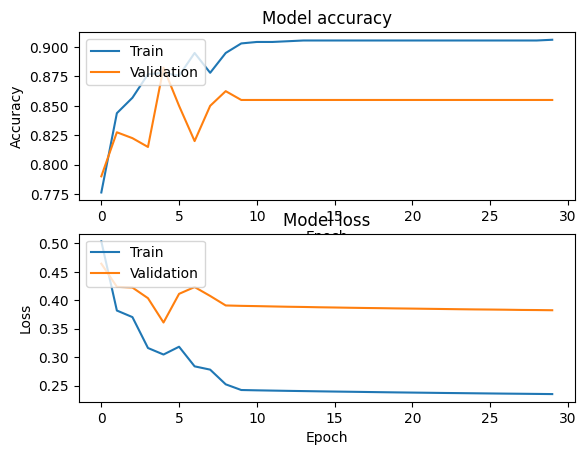

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Confusion Matrix:
[[185  16]
 [ 42 157]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       201
           1       0.91      0.79      0.84       199

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400

Model already save


In [53]:
# LSTM with learning rate (auto) and epoch 30
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr='auto', epochs=30, names='28_LSTM_lr_auto')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.7167 - loss: 0.5714 - val_accuracy: 0.7675 - val_loss: 0.5560
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7518 - loss: 0.5319 - val_accuracy: 0.7425 - val_loss: 0.5138
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.7556 - loss: 0.4882 - val_accuracy: 0.7500 - val_loss: 0.5072
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.7841 - loss: 0.4678 - val_accuracy: 0.7625 - val_loss: 0.4932
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.7456 - loss: 0.5105 - val_accuracy: 0.7700 - val_loss: 0.4927
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.7692 - loss: 0.4858 - val_accuracy: 0.7575 - val_loss: 0.5013
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.7833 - loss: 0.4838 - val_accuracy: 0.7950 - val_loss: 0.4893
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.7764 - loss: 0.4707 - val_accuracy: 0

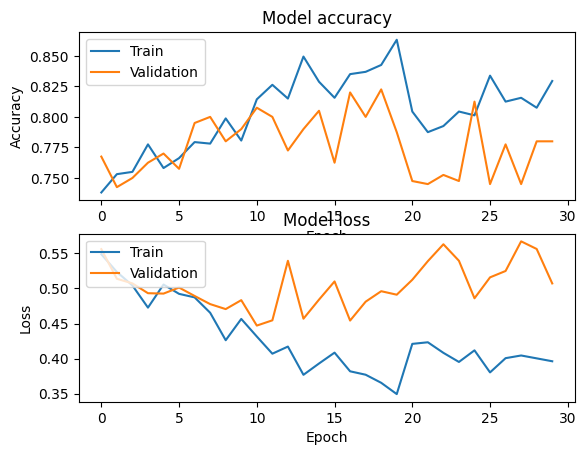

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Confusion Matrix:
[[135  66]
 [ 22 177]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75       201
           1       0.73      0.89      0.80       199

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.79      0.78      0.78       400

Model already save


In [54]:
# GRU with learning rate (0.01) and epoch 30
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=30, names='29_GRU_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.7483 - loss: 0.5404 - val_accuracy: 0.7875 - val_loss: 0.4757
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8405 - loss: 0.3947 - val_accuracy: 0.8175 - val_loss: 0.4277
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8605 - loss: 0.3414 - val_accuracy: 0.8400 - val_loss: 0.4269
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8434 - loss: 0.3654 - val_accuracy: 0.8225 - val_loss: 0.4408
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.8654 - loss: 0.3327 - val_accuracy: 0.8325 - val_loss: 0.3891
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.8715 - loss: 0.3181 - val_accuracy: 0.7775 - val_loss: 0.5066
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.8607 - loss: 0.3611 - val_accuracy: 0.8700 - val_loss: 0.3982
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9038 - loss: 0.2620 - val_accuracy: 0

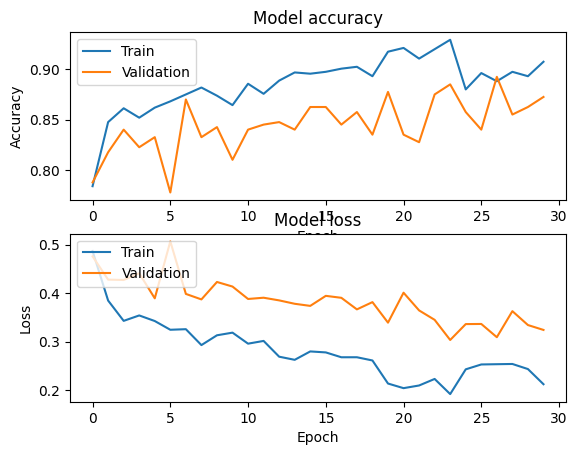

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Confusion Matrix:
[[190  11]
 [ 40 159]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       201
           1       0.94      0.80      0.86       199

    accuracy                           0.87       400
   macro avg       0.88      0.87      0.87       400
weighted avg       0.88      0.87      0.87       400

Model already save


In [55]:
# GRU with learning rate (0.001) and epoch 30
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=30, names='30_GRU_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.7306 - loss: 0.5371 - val_accuracy: 0.8225 - val_loss: 0.4374
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8710 - loss: 0.3516 - val_accuracy: 0.8750 - val_loss: 0.3519
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9059 - loss: 0.2735 - val_accuracy: 0.8750 - val_loss: 0.3247
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9261 - loss: 0.2227 - val_accuracy: 0.8925 - val_loss: 0.2789
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9401 - loss: 0.1706 - val_accuracy: 0.9000 - val_loss: 0.2635
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9540 - loss: 0.1351 - val_accuracy: 0.9075 - val_loss: 0.2467
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9541 - loss: 0.1205 - val_accuracy: 0.9175 - val_loss: 0.2470
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9762 - loss: 0.0987 - val_accuracy: 0

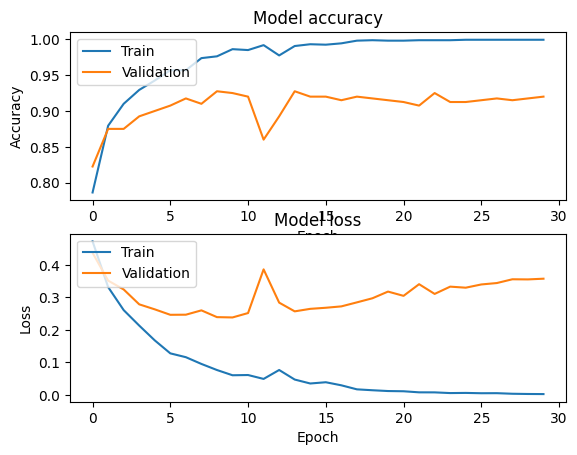

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Confusion Matrix:
[[190  11]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       201
           1       0.94      0.89      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

Model already save


In [56]:
# GRU with learning rate (0.0001) and epoch 30
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=30, names='31_GRU_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.7636 - loss: 0.5233 - val_accuracy: 0.8400 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8514 - loss: 0.3653 - val_accuracy: 0.8450 - val_loss: 0.3979 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.8708 - loss: 0.3336 - val_accuracy: 0.8500 - val_loss: 0.3888 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.8772 - loss: 0.3216 - val_accuracy: 0.7875 - val_loss: 0.5032 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8564 - loss: 0.3435 - val_accuracy: 0.8350 - val_loss: 0.4210 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8807 - loss: 0.2998 - val_accuracy: 0.8625 - val_loss: 0.4044 - learning_rate: 1.0000e-05
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8998 - loss: 0.26

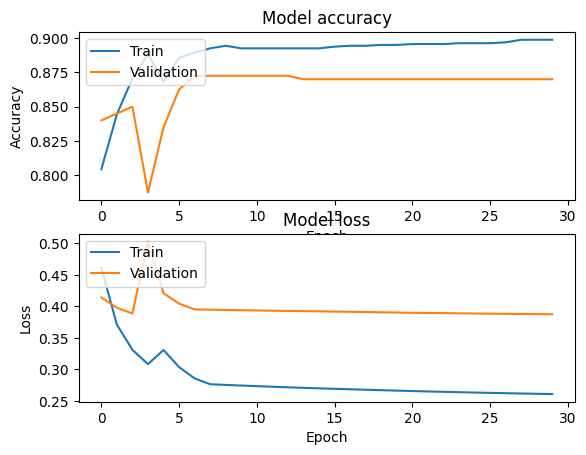

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
Confusion Matrix:
[[175  26]
 [ 26 173]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       201
           1       0.87      0.87      0.87       199

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

Model already save


In [57]:
# GRU with learning rate (auto) and epoch 30
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr='auto', epochs=30, names='32_GRU_lr_auto')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 308ms/step - accuracy: 0.6859 - loss: 15.2598 - val_accuracy: 0.8450 - val_loss: 2.0678
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - accuracy: 0.7506 - loss: 2.8262 - val_accuracy: 0.7800 - val_loss: 1.4770
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.8501 - loss: 0.9360 - val_accuracy: 0.8425 - val_loss: 0.6735
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 294ms/step - accuracy: 0.8626 - loss: 0.3920 - val_accuracy: 0.8450 - val_loss: 0.6527
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 0.8736 - loss: 0.3950 - val_accuracy: 0.8600 - val_loss: 0.5812
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.9399 - loss: 0.1760 - val_accuracy: 0.8300 - val_loss: 0.8559
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - accuracy: 0.9391 - loss: 0.1728 - val_accuracy: 0.8950 - val_loss: 0.6601
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.9517 - loss: 0.1826 - val_acc

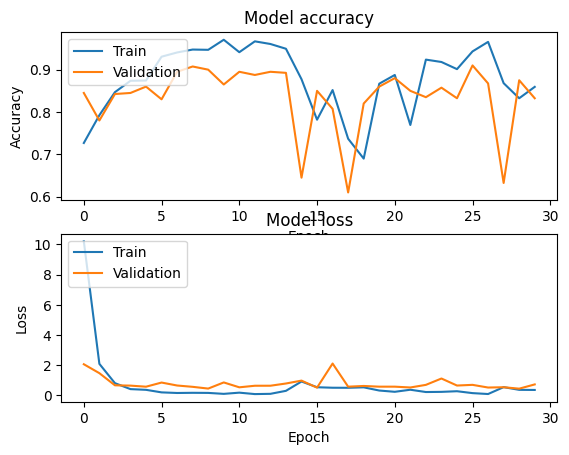

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Confusion Matrix:
[[195   6]
 [ 61 138]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       201
           1       0.96      0.69      0.80       199

    accuracy                           0.83       400
   macro avg       0.86      0.83      0.83       400
weighted avg       0.86      0.83      0.83       400

Model already save


In [58]:
# TCN with learning rate (0.01) and epoch 30
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=30, names='33_TCN_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 319ms/step - accuracy: 0.7241 - loss: 1.5668 - val_accuracy: 0.7875 - val_loss: 0.5767
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.8380 - loss: 0.6887 - val_accuracy: 0.7925 - val_loss: 0.9050
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.8668 - loss: 0.4467 - val_accuracy: 0.8825 - val_loss: 0.6422
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.9304 - loss: 0.2834 - val_accuracy: 0.8925 - val_loss: 0.4649
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.9513 - loss: 0.1656 - val_accuracy: 0.8650 - val_loss: 0.4955
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.9690 - loss: 0.1274 - val_accuracy: 0.9025 - val_loss: 0.4510
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - accuracy: 0.9763 - loss: 0.0708 - val_accuracy: 0.8775 - val_loss: 0.4610
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.9896 - loss: 0.0355 - val_accu

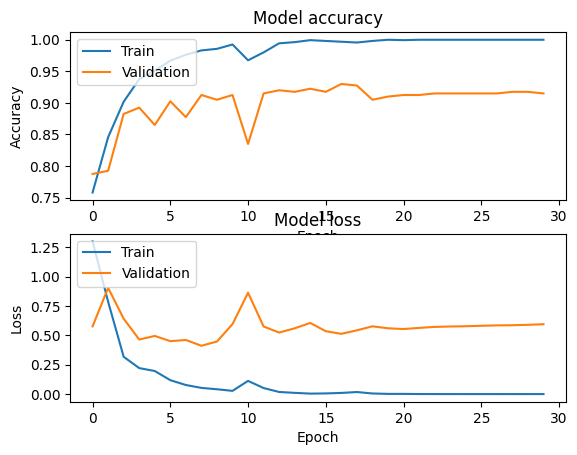

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:
[[190  11]
 [ 23 176]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       201
           1       0.94      0.88      0.91       199

    accuracy                           0.92       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.92      0.91       400

Model already save


In [59]:
# TCN with learning rate (0.001) and epoch 30
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=30, names='34_TCN_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.7385 - loss: 0.5054 - val_accuracy: 0.8575 - val_loss: 0.4247
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.8780 - loss: 0.2901 - val_accuracy: 0.8400 - val_loss: 0.3959
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 294ms/step - accuracy: 0.9247 - loss: 0.2094 - val_accuracy: 0.8975 - val_loss: 0.3283
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.9611 - loss: 0.1283 - val_accuracy: 0.9125 - val_loss: 0.3091
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.9756 - loss: 0.1058 - val_accuracy: 0.8825 - val_loss: 0.3474
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.9775 - loss: 0.0928 - val_accuracy: 0.9225 - val_loss: 0.3361
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.9886 - loss: 0.0497 - val_accuracy: 0.9000 - val_loss: 0.4040
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.9842 - loss: 0.0484 - val_accu

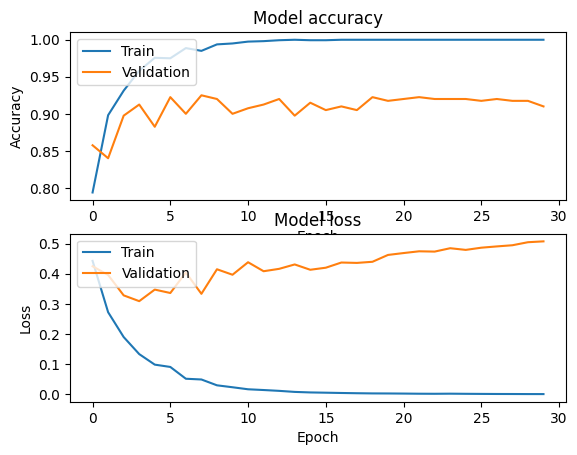

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:
[[189  12]
 [ 24 175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       201
           1       0.94      0.88      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [60]:
# TCN with learning rate (0.0001) and epoch 30
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=30, names='35_TCN_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.7454 - loss: 1.4654 - val_accuracy: 0.7675 - val_loss: 1.3431 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.8690 - loss: 0.6353 - val_accuracy: 0.8325 - val_loss: 0.5970 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - accuracy: 0.9400 - loss: 0.2655 - val_accuracy: 0.8350 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 0.9497 - loss: 0.1540 - val_accuracy: 0.8825 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.9355 - loss: 0.1671 - val_accuracy: 0.9000 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 334ms/step - accuracy: 0.9729 - loss: 0.0923 - val_accuracy: 0.9025 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.9827 - loss: 0.

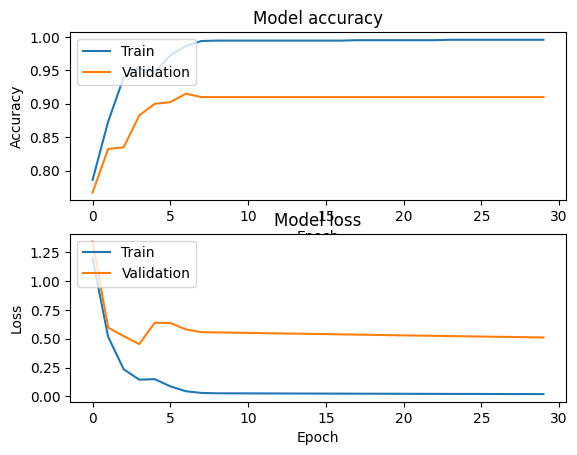

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Confusion Matrix:
[[189  12]
 [ 24 175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       201
           1       0.94      0.88      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [61]:
# TCN with learning rate (auto) and epoch 30
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr='auto', epochs=30, names='36_TCN_lr_auto')

## Auto Epoch with EarlyStopping

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.7229 - loss: 0.5685 - val_accuracy: 0.7875 - val_loss: 0.5538
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7815 - loss: 0.5006 - val_accuracy: 0.7850 - val_loss: 0.5143
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7932 - loss: 0.4580 - val_accuracy: 0.8325 - val_loss: 0.4373
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.7616 - loss: 0.4738 - val_accuracy: 0.7675 - val_loss: 0.4797
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7940 - loss: 0.4562 - val_accuracy: 0.7125 - val_loss: 0.5050
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7706 - loss: 0.4813 - val_accuracy: 0.7275 - val_loss: 0.5468
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7923 - loss: 0.4780 - val_accuracy: 0.7825 - val_loss: 0.4951
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7801 - loss: 0.4697 -

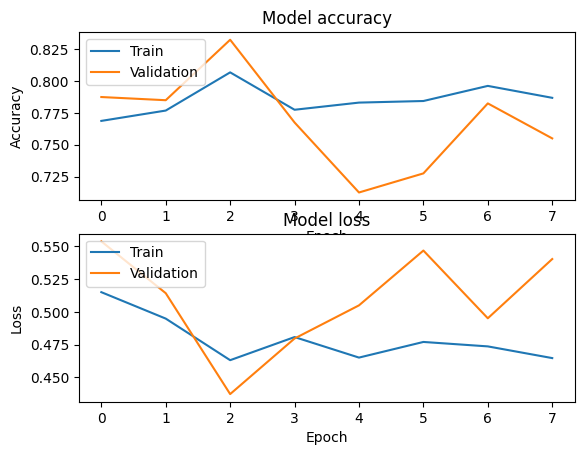

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Confusion Matrix:
[[163  38]
 [ 29 170]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       201
           1       0.82      0.85      0.84       199

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

Model already save


In [38]:
# LSTM with learning rate (0.01) and epoch auto
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.01, epochs='auto', names='37_LSTM_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.7476 - loss: 0.5602 - val_accuracy: 0.8325 - val_loss: 0.4511
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8484 - loss: 0.4075 - val_accuracy: 0.8475 - val_loss: 0.3862
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8756 - loss: 0.3189 - val_accuracy: 0.8700 - val_loss: 0.3666
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.8617 - loss: 0.3300 - val_accuracy: 0.8525 - val_loss: 0.3740
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8807 - loss: 0.2970 - val_accuracy: 0.7975 - val_loss: 0.4877
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.8844 - loss: 0.3214 - val_accuracy: 0.8500 - val_loss: 0.4239
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.8838 - loss: 0.3008 - val_accuracy: 0.8625 - val_loss: 0.3734
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9162 - loss: 0.2472 -

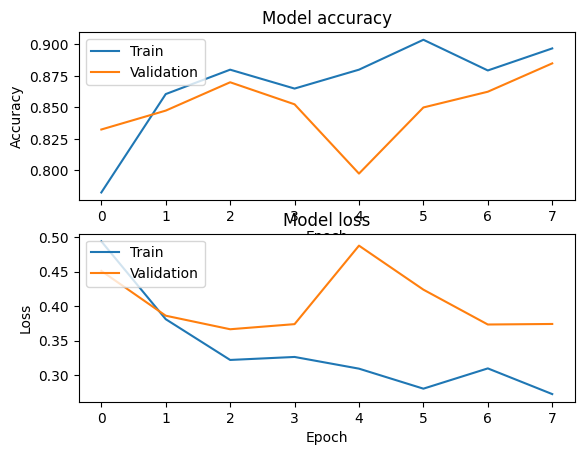

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Confusion Matrix:
[[179  22]
 [ 30 169]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       201
           1       0.88      0.85      0.87       199

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

Model already save


In [39]:
# LSTM with learning rate (0.001) and epoch auto
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.001, epochs='auto', names='38_LSTM_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.7356 - loss: 0.5984 - val_accuracy: 0.8675 - val_loss: 0.4903
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.8655 - loss: 0.4428 - val_accuracy: 0.8875 - val_loss: 0.4034
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.8969 - loss: 0.3487 - val_accuracy: 0.8900 - val_loss: 0.3465
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9319 - loss: 0.2588 - val_accuracy: 0.8975 - val_loss: 0.3179
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9332 - loss: 0.2344 - val_accuracy: 0.9050 - val_loss: 0.3057
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9229 - loss: 0.2162 - val_accuracy: 0.8950 - val_loss: 0.2994
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9438 - loss: 0.1700 - val_accuracy: 0.8950 - val_loss: 0.2813
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9513 - loss: 0.1510 -

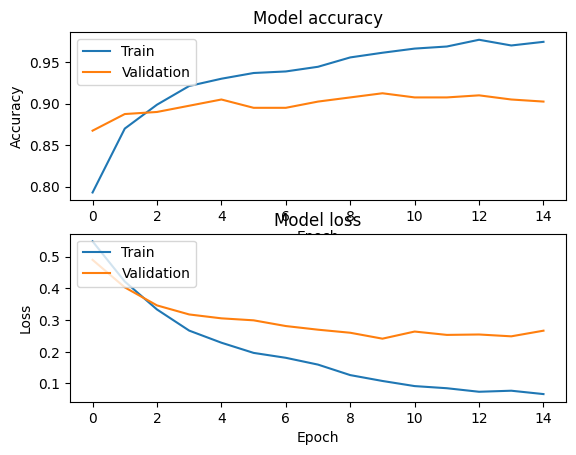

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Confusion Matrix:
[[188  13]
 [ 22 177]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.91       201
           1       0.93      0.89      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Model already save


In [40]:
# LSTM with learning rate (0.0001) and epoch auto
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs='auto', names='39_LSTM_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.7214 - loss: 0.5637 - val_accuracy: 0.8400 - val_loss: 0.4372 - learning_rate: 0.0010
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.8436 - loss: 0.3972 - val_accuracy: 0.8475 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8616 - loss: 0.3434 - val_accuracy: 0.8150 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8552 - loss: 0.3577 - val_accuracy: 0.8375 - val_loss: 0.4229 - learning_rate: 0.0010
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8621 - loss: 0.3798 - val_accuracy: 0.8625 - val_loss: 0.3989 - learning_rate: 1.0000e-05
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8711 - loss: 0.3446 - val_accuracy: 0.8500 - val_loss: 0.3885 - learning_rate: 1.0000e-05
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0

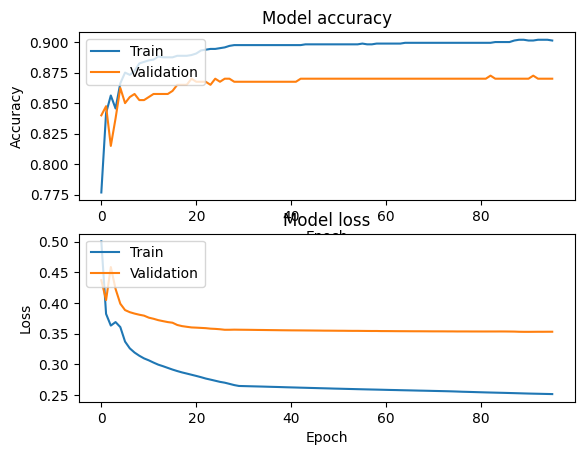

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Confusion Matrix:
[[177  24]
 [ 28 171]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       201
           1       0.88      0.86      0.87       199

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

Model already save


In [41]:
# LSTM with learning rate (auto) and epoch auto
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr='auto', epochs='auto', names='40_LSTM_lr_auto')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7199 - loss: 0.5696 - val_accuracy: 0.7725 - val_loss: 0.4984
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8089 - loss: 0.4338 - val_accuracy: 0.7600 - val_loss: 0.4946
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.7615 - loss: 0.4958 - val_accuracy: 0.7750 - val_loss: 0.4785
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.7688 - loss: 0.4711 - val_accuracy: 0.7225 - val_loss: 0.5017
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.7253 - loss: 0.4934 - val_accuracy: 0.7850 - val_loss: 0.4698
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.8124 - loss: 0.4383 - val_accuracy: 0.7550 - val_loss: 0.4794
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.7963 - loss: 0.4401 - val_accuracy: 0.7650 - val_loss: 0.5705
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.7883 - loss: 0.4775 -

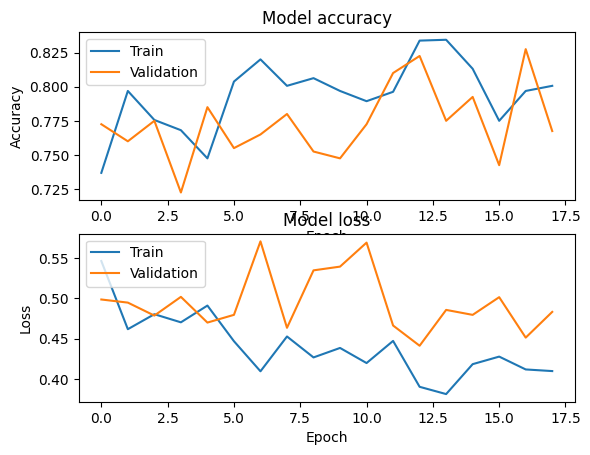

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Confusion Matrix:
[[154  47]
 [ 24 175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       201
           1       0.79      0.88      0.83       199

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400

Model already save


In [42]:
# GRU with learning rate (0.01) and epoch auto
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.01, epochs='auto', names='41_GRU_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.7276 - loss: 0.5406 - val_accuracy: 0.8475 - val_loss: 0.4135
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8537 - loss: 0.3657 - val_accuracy: 0.8550 - val_loss: 0.4036
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8595 - loss: 0.3651 - val_accuracy: 0.8725 - val_loss: 0.3812
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8576 - loss: 0.3446 - val_accuracy: 0.8125 - val_loss: 0.4422
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8698 - loss: 0.3186 - val_accuracy: 0.8350 - val_loss: 0.4329
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8812 - loss: 0.3048 - val_accuracy: 0.8300 - val_loss: 0.4292
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8585 - loss: 0.3148 - val_accuracy: 0.8725 - val_loss: 0.3721
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.8942 - loss: 0.2751 -

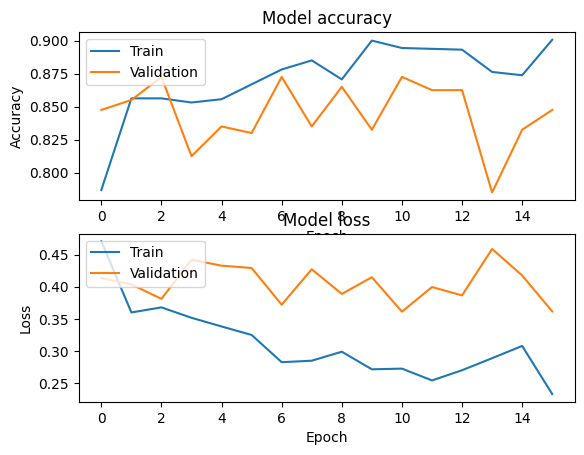

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Confusion Matrix:
[[181  20]
 [ 31 168]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       201
           1       0.89      0.84      0.87       199

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

Model already save


In [43]:
# GRU with learning rate (0.001) and epoch auto
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.001, epochs='auto', names='42_GRU_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.7564 - loss: 0.5192 - val_accuracy: 0.8425 - val_loss: 0.4013
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8795 - loss: 0.3306 - val_accuracy: 0.8800 - val_loss: 0.3540
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9097 - loss: 0.2711 - val_accuracy: 0.9025 - val_loss: 0.3068
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9103 - loss: 0.2470 - val_accuracy: 0.8800 - val_loss: 0.3078
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9291 - loss: 0.1914 - val_accuracy: 0.9000 - val_loss: 0.2737
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9421 - loss: 0.1570 - val_accuracy: 0.9100 - val_loss: 0.2761
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9451 - loss: 0.1436 - val_accuracy: 0.9150 - val_loss: 0.2513
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9718 - loss: 0.1098 -

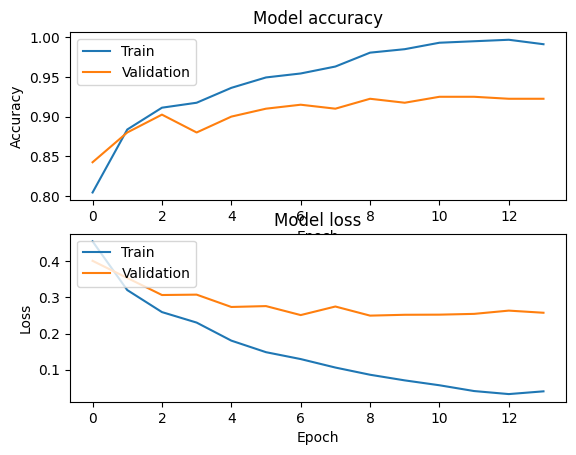

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Confusion Matrix:
[[191  10]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       201
           1       0.95      0.89      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

Model already save


In [44]:
# GRU with learning rate (0.0001) and epoch auto
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs='auto', names='43_GRU_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.7493 - loss: 0.5318 - val_accuracy: 0.7975 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8483 - loss: 0.3722 - val_accuracy: 0.8075 - val_loss: 0.4163 - learning_rate: 0.0010
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8723 - loss: 0.3100 - val_accuracy: 0.8625 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8855 - loss: 0.2977 - val_accuracy: 0.8475 - val_loss: 0.3941 - learning_rate: 0.0010
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8966 - loss: 0.2585 - val_accuracy: 0.8625 - val_loss: 0.3722 - learning_rate: 0.0010
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9029 - loss: 0.2589 - val_accuracy: 0.8800 - val_loss: 0.3545 - learning_rate: 1.0000e-05
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.906

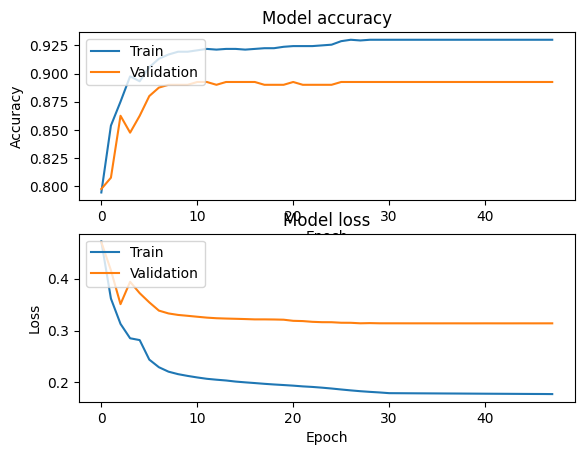

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Confusion Matrix:
[[186  15]
 [ 28 171]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       201
           1       0.92      0.86      0.89       199

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400

Model already save


In [45]:
# GRU with learning rate (auto) and epoch auto
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr='auto', epochs='auto', names='44_GRU_lr_auto')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.6556 - loss: 13.6267 - val_accuracy: 0.6850 - val_loss: 3.7628
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.7604 - loss: 2.2311 - val_accuracy: 0.7550 - val_loss: 0.6475
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.8492 - loss: 0.3911 - val_accuracy: 0.8425 - val_loss: 0.3945
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.8692 - loss: 0.3270 - val_accuracy: 0.8350 - val_loss: 0.4256
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.9138 - loss: 0.2274 - val_accuracy: 0.8875 - val_loss: 0.3912
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.9192 - loss: 0.2531 - val_accuracy: 0.8875 - val_loss: 0.4027
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.9287 - loss: 0.1721 - val_accuracy: 0.8575 - val_loss: 0.5776
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9519 - loss: 

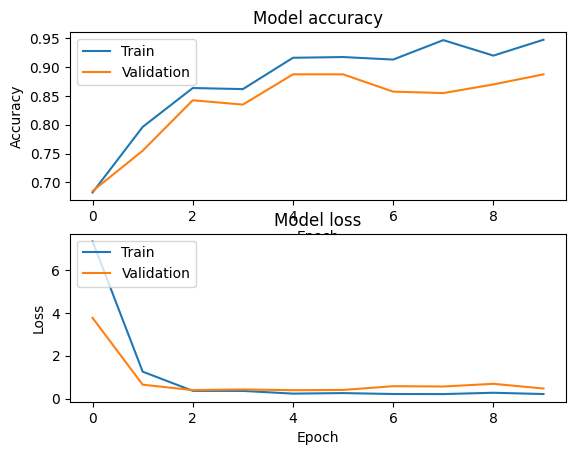

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Confusion Matrix:
[[173  28]
 [ 17 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       201
           1       0.87      0.91      0.89       199

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400

Model already save


In [46]:
# TCN with learning rate (0.01) and epoch auto
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.01, epochs='auto', names='45_TCN_lr_1e-2')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.7112 - loss: 1.4154 - val_accuracy: 0.7425 - val_loss: 0.7265
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.8630 - loss: 0.5820 - val_accuracy: 0.8125 - val_loss: 0.5761
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.9336 - loss: 0.1823 - val_accuracy: 0.8425 - val_loss: 0.4503
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.9626 - loss: 0.1179 - val_accuracy: 0.8150 - val_loss: 0.8345
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9306 - loss: 0.1933 - val_accuracy: 0.9000 - val_loss: 0.4500
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - accuracy: 0.9789 - loss: 0.0561 - val_accuracy: 0.9050 - val_loss: 0.5170
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9914 - loss: 0.0388 - val_accuracy: 0.9200 - val_loss: 0.4059
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9879 - loss: 0

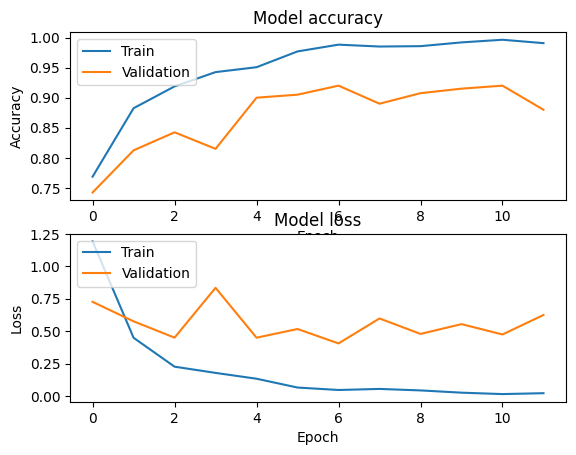

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:
[[185  16]
 [ 16 183]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       201
           1       0.92      0.92      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

Model already save


In [47]:
# TCN with learning rate (0.001) and epoch auto
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.001, epochs='auto', names='46_TCN_lr_1e-3')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.7062 - loss: 0.5804 - val_accuracy: 0.8250 - val_loss: 0.4305
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.8762 - loss: 0.3002 - val_accuracy: 0.8450 - val_loss: 0.3622
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - accuracy: 0.9266 - loss: 0.2020 - val_accuracy: 0.8925 - val_loss: 0.3099
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.9611 - loss: 0.1348 - val_accuracy: 0.9125 - val_loss: 0.2988
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.9721 - loss: 0.0988 - val_accuracy: 0.8800 - val_loss: 0.3282
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.9764 - loss: 0.0807 - val_accuracy: 0.9225 - val_loss: 0.2870
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.9937 - loss: 0.0405 - val_accuracy: 0.9125 - val_loss: 0.3086
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.9904 - loss: 0

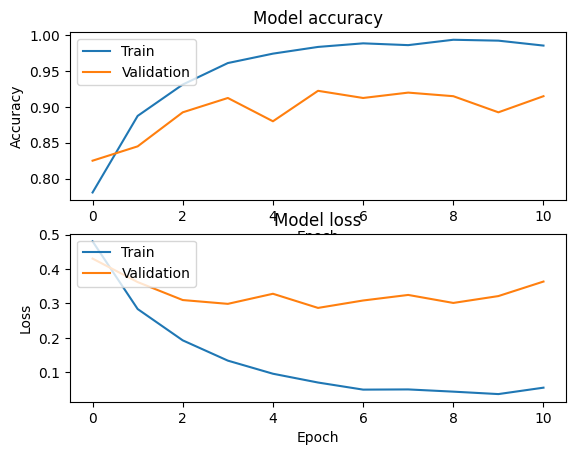

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Confusion Matrix:
[[190  11]
 [ 20 179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       201
           1       0.94      0.90      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

Model already save


In [48]:
# TCN with learning rate (0.0001) and epoch auto
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs='auto', names='47_TCN_lr_1e-4')

C:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.7165 - loss: 1.4071 - val_accuracy: 0.8000 - val_loss: 1.1203 - learning_rate: 0.0010
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.8712 - loss: 0.6719 - val_accuracy: 0.8275 - val_loss: 0.5666 - learning_rate: 0.0010
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.9293 - loss: 0.2166 - val_accuracy: 0.8475 - val_loss: 0.5599 - learning_rate: 0.0010
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9496 - loss: 0.1680 - val_accuracy: 0.8550 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9566 - loss: 0.1444 - val_accuracy: 0.8250 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.9628 - loss: 0.1089 - val_accuracy: 0.8525 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9

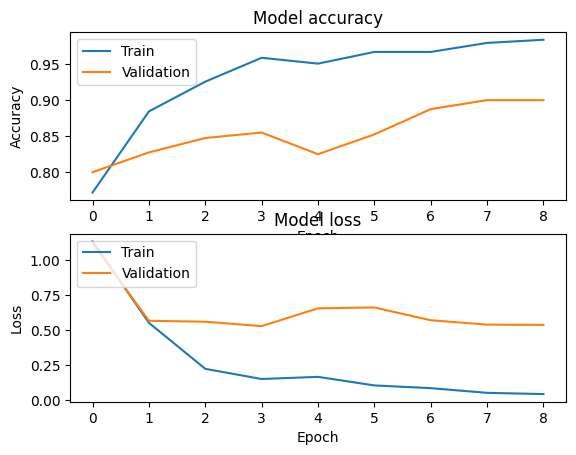

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Confusion Matrix:
[[180  21]
 [ 37 162]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       201
           1       0.89      0.81      0.85       199

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400

Model already save


In [49]:
# TCN with learning rate (auto) and epoch auto
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr='auto', epochs='auto', names='48_TCN_lr_auto')